In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from glob import glob
import shutil
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, BatchNormalization, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image

In [2]:
IMAGE_SIZE=[224,224]

In [3]:
os.chdir('D:\\')
wd=os.getcwd()
wd

'D:\\'

In [4]:
dataset_dir=wd+"pirojetc"
train_dir=dataset_dir+"/train"
test_dir=dataset_dir+"/val"
path=[train_dir, test_dir]
folders=glob(train_dir+'/*')
folders
len(folders)

5

# GETTING NAMES OF ALL THE CLASSES

In [5]:
path = train_dir
class_lst = os.listdir(path) 
print("Files and directories in '", path, "' :")
print(class_lst)

Files and directories in ' D:\pirojetc/train ' :
['ben_afflek', 'elton_john', 'jerry_seinfeld', 'madonna', 'mindy_kaling']


# GOING THROUGH A DATASET

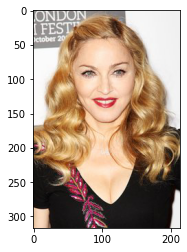

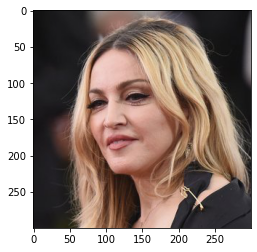

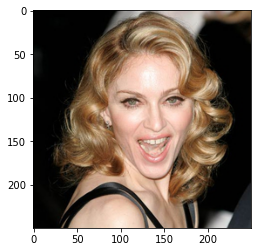

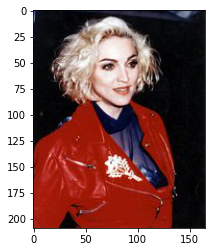

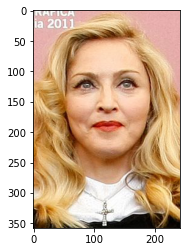

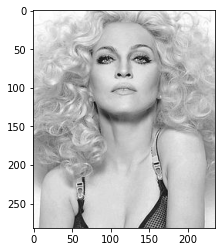

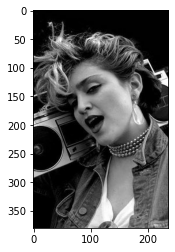

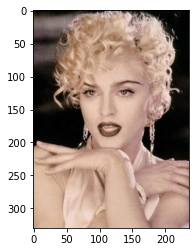

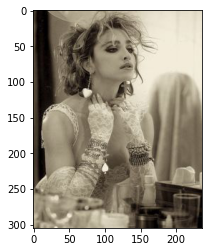

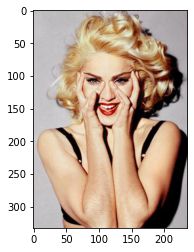

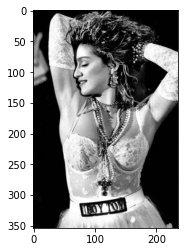

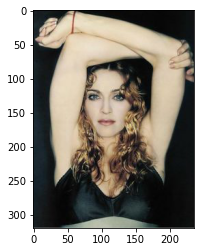

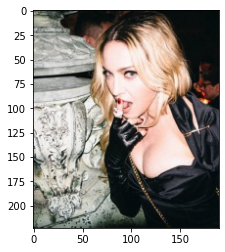

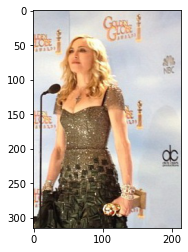

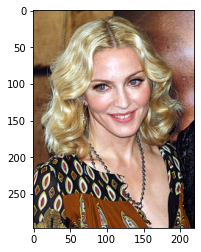

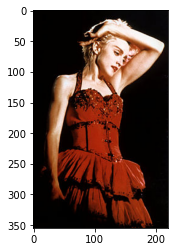

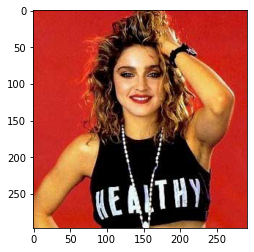

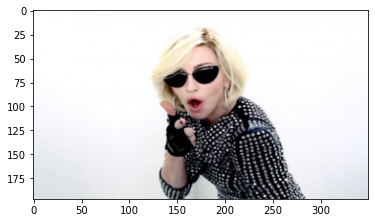

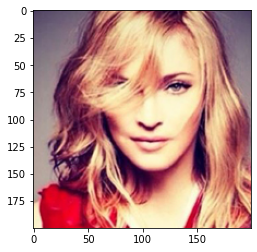

In [6]:
def process(filename: str=None) -> None:
    image = mpimg.imread(filename)
    plt.figure()
    plt.imshow(image)
for filename in os.listdir(path + "/madonna"):
    process(path + "/madonna" + '/' + filename)

# MAKING TEST AND VAILDATE FOLDERS

In [7]:
test=dataset_dir+'/test'
validate=dataset_dir+'/validate'
fpath=[test, validate]
for folderpath in fpath:
    if not os.path.exists(folderpath):
        os.makedirs(folderpath)

# MAKING CLASS FOLDERS UNDER TRAIN AND VALIDATE FOLDERS

In [8]:
for clsname in class_lst:
    path = os.path.join(test, clsname)
    if not os.path.exists(path):
        os.makedirs(path)
        
for clsname in class_lst:
    path = os.path.join(validate, clsname)
    if not os.path.exists(path):
        os.makedirs(path)        

In [10]:
## Function for Creating Train / Validation / Test folders (One time use Only)
 
def TrainValTestSplit(root_dir, classes_dir, test_ratio = 0.40):
    main_folder = './project_facedata_splitted/';

    for cls in classes_dir:
        os.makedirs(main_folder + 'val' + '/'+ cls)
        os.makedirs(main_folder + 'test' + '/'+ cls)

        src = root_dir + '/'+ cls
        
        allFileNames = os.listdir(src)
        print(allFileNames)
        np.random.seed(0)
        np.random.shuffle(allFileNames)

        val_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* (1 - (test_ratio)))])

        val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
        test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

        print(cls.upper(),':')
        print('Total images: ', len(allFileNames))
        print('Validation: ', len(val_FileNames))
        print('Testing: ', len(test_FileNames))

        for name in val_FileNames:
            shutil.copy(name, main_folder + 'val' + '/'+ cls)

        for name in test_FileNames:
            shutil.copy(name, main_folder + 'test' + '/'+ cls)
        print()

root_dir = test_dir              
TrainValTestSplit(root_dir, class_lst)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: './project_facedata_splitted/val/ben_afflek'

# TRANSFER LEARNING

In [9]:
vgg19 = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# NON TRAINABLE LAYERS

In [10]:
for layer in vgg19.layers:
    layer.trainable=False
folders=glob(train_dir + '/*')   

In [11]:
x = Flatten()(vgg19.output)
prediction=Dense(len(folders), activation='softmax')(x)

model = Model(inputs=vgg19.input, outputs=prediction)

In [12]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [13]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(0.001),
    metrics=['accuracy']
)

In [14]:
## Image Data Augmentation

train_datagen = ImageDataGenerator(rescale=1/255,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True)

val_datagen = image.ImageDataGenerator(rescale = 1./255)

test_datagen = image.ImageDataGenerator(rescale = 1./255)

TRAIN_DIR = './project_facedata_splitted/train'
VAL_DIR = './project_facedata_splitted/val'
TEST_DIR = './project_facedata_splitted/test'

In [15]:
training_set = train_datagen.flow_from_directory(TRAIN_DIR,
                                                target_size=(224,224),
                                                batch_size=8,
                                                class_mode='categorical',
                                                shuffle=False)

validation_set = val_datagen.flow_from_directory(VAL_DIR,
                                                target_size=(224,224),
                                                batch_size=8,
                                                class_mode='categorical',
                                                shuffle=False)

testing_set = test_datagen.flow_from_directory(TEST_DIR,
                                                target_size=(224,224),
                                                batch_size=8,
                                                class_mode='categorical',
                                              shuffle=False)

Found 93 images belonging to 5 classes.
Found 15 images belonging to 5 classes.
Found 10 images belonging to 5 classes.


In [116]:
r = model.fit(
    training_set,
    validation_data=validation_set,
    epochs = 25,
    steps_per_epoch = training_set.samples//training_set.batch_size,
    validation_steps = validation_set.samples//validation_set.batch_size
)

Epoch 1/25
11/11 [==============================] - 17s 2s/step - loss: 8.1760 - accuracy: 0.0353 - val_loss: 5.6767 - val_accuracy: 0.0000e+00
Epoch 2/25
11/11 [==============================] - 18s 2s/step - loss: 4.3241 - accuracy: 0.2824 - val_loss: 4.6134 - val_accuracy: 0.2500
Epoch 3/25
11/11 [==============================] - 19s 2s/step - loss: 2.1662 - accuracy: 0.3647 - val_loss: 2.9106 - val_accuracy: 0.2500
Epoch 4/25
11/11 [==============================] - 18s 2s/step - loss: 1.2487 - accuracy: 0.5294 - val_loss: 1.2733 - val_accuracy: 0.3750
Epoch 5/25
11/11 [==============================] - 19s 2s/step - loss: 0.8574 - accuracy: 0.6588 - val_loss: 1.6495 - val_accuracy: 0.3750
Epoch 6/25
11/11 [==============================] - 19s 2s/step - loss: 1.2965 - accuracy: 0.6000 - val_loss: 1.5953 - val_accuracy: 0.3750
Epoch 7/25
11/11 [==============================] - 21s 2s/step - loss: 1.0630 - accuracy: 0.6136 - val_loss: 1.4526 - val_accuracy: 0.3750
Epoch 8/25
11/11

In [119]:
model.evaluate_generator(generator= validation_set)[1]

0.9333333373069763

In [120]:
model.evaluate_generator(generator= testing_set)[1]

0.699999988079071

In [16]:
model.save('saved_models/model.hdf5')